# Passer Ratings: Physical attributes 🤙 💪 🧍

Hypothesis: Hand size/height/arm length affects average career passer rating.

In [235]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import mysql.connector
import sys
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import pymc3 as pm
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load

We drop a QB's season if they had less than 50 attempts, as that's too small sample size to be a reasonable reflection of skill.

In [236]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
sql = open('../sql/qb_season_ratings.sql', 'r').read()
df = pd.read_sql(sql, cnx)
df = df.loc[:,~df.columns.duplicated()][df['attempts']>50].set_index(['player','year'])

## Clean

The dataset uses empty strings as missing values. We'll change that to NaN.

In [237]:
df = df.apply(lambda x: x.replace('', np.nan))

# physical
df.loc[df['hand']<1, 'hand'] = np.nan
df['hand'] = df.groupby('player')['hand'].apply(lambda x: x.fillna(method='ffill'))
df.loc[df['height']<1, 'height'] = np.nan
df.loc[df['weight']<1, 'weight'] = np.nan
df.loc[df['arm']<1, 'arm'] = np.nan

# combine
df.loc[df['broad']<1, 'broad'] = np.nan
df.loc[df['cone']<1, 'cone'] = np.nan
df.loc[df['shuttle']<1, 'shuttle'] = np.nan 

df.describe()

,attempts,completions,yards,interceptions,TD,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,...,vertical,broad,shuttle,cone,arm,hand,dpos,start,jnum,dcp
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,...,1014.000000,528.000000,551.000000,539.000000,485.000000,515.00000,1014.000000,1014.000000,1014.000000,1014.000000
mean,346.623274,211.994083,2435.874753,9.706114,14.737673,80.376627,0.067296,0.030572,0.084831,0.423961,...,17.377712,111.323864,4.283013,7.121744,32.135309,9.59213,57.834320,2003.830375,3.279093,0.696252
std,197.733500,128.141549,1511.868073,5.688563,11.215744,15.095219,0.027190,0.094902,0.109693,0.269861,...,16.140787,6.963120,0.167032,0.229315,1.047378,0.46930,73.885134,7.164602,5.075347,1.101218
min,51.000000,18.000000,167.000000,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,0.000000,...,0.000000,96.000000,3.900000,6.660000,28.500000,8.25000,0.000000,1985.000000,0.000000,0.000000
25%,160.250000,93.000000,1020.750000,5.000000,5.000000,71.025000,0.048425,0.000000,0.000000,0.200000,...,0.000000,106.000000,4.175000,6.950000,31.250000,9.26800,1.000000,1999.000000,0.000000,0.000000
50%,341.500000,204.000000,2321.500000,9.000000,12.000000,81.050000,0.064000,0.000000,0.058800,0.333300,...,26.500000,111.000000,4.280000,7.110000,32.000000,9.50000,22.000000,2004.000000,0.000000,0.000000
75%,525.750000,320.000000,3705.750000,14.000000,22.000000,90.600000,0.082775,0.000000,0.133300,0.666700,...,32.500000,116.000000,4.380000,7.210000,32.875000,9.87500,93.000000,2009.000000,7.000000,1.000000
max,787.000000,541.000000,6404.000000,30.000000,60.000000,121.000000,0.194000,0.750000,0.750000,1.000000,...,39.000000,127.000000,4.780000,7.800000,35.000000,10.87500,285.000000,2019.000000,19.000000,5.000000


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           83 non-n

Lets load in combine data we scraped outside of this notebook. The combine data includes physical attributes measured at the start of the players career. We add these features to the QB frame.

In [239]:
def fill(group, cols, data):
    group = group.reset_index(-1)
    for col in cols:
        if col not in group.columns:
            group[col] = np.nan
        group[col] = group[col].fillna(data[col])
    group = group.set_index('year', append=True)
    return group

In [240]:
qb_combine = pd.read_csv(f'../data/combine_qb_200309.csv', index_col=0)
cols = qb_combine.drop(['fname','lname'], axis=1).columns.values
qb_combine

,fname,lname,arm,hand,shuttle,cone,broad,wonderlic,ball_speed
player,,,,,,,,,
AB-2900,Aaron,Brooks,32.000,9.500,4.29,7.52,120.0,17.0,NaN
AF-0300,A.J.,Feeley,NaN,NaN,4.16,NaN,NaN,NaN,NaN
AS-1400,Akili,Smith,32.250,9.750,4.29,6.99,114.0,26.0,NaN
AS-1600,Alex,Smith,31.750,9.375,3.97,6.82,113.0,40.0,NaN
AV-0200,Alex,Van Pelt,31.880,9.750,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TS-2600,Troy,Smith,31.000,8.250,4.24,7.25,NaN,NaN,NaN
TT-0900,Tyler,Thigpen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT-0200,Vinny,Testaverde,33.500,10.000,NaN,NaN,NaN,NaN,NaN


In [241]:
df = df.groupby('player').apply(lambda x: fill(x, cols, qb_combine))

In [242]:
df.loc['AB-2900', 'hand']

year
2001    9.5
2004    9.5
2002    9.5
2003    9.5
2005    9.5
2000    9.5
2006    9.5
Name: hand, dtype: float64

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           83 non-n

In [244]:
df_subset = df.loc[:,['attempts','avg_rating','sack_rate','alt_rate','precip_rate','turf_rate','wind_rate','away_rate','temp','height','arm','start','hand']].reset_index()
df_subset

,player,year,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,arm,start,hand
0,DB-3800,2011,763.0,110.6,0.0365,0.0000,0.0000,0.7222,2.333333,0.5000,68.944444,72.0,31.250,2001,10.000
1,PM-0200,2013,787.0,111.7,0.0223,0.5263,0.0526,0.2632,7.526316,0.4211,57.578947,77.0,31.500,1998,10.130
2,EM-0200,2011,752.0,95.1,0.0493,0.0000,0.1000,0.7500,7.850000,0.5500,57.550000,77.0,30.750,2004,9.750
3,TB-2300,2011,722.0,104.8,0.0462,0.0526,0.0000,0.6316,7.842105,0.4211,55.000000,76.0,32.750,2000,9.380
4,MR-2500,2016,632.0,119.9,0.0661,0.0526,0.0526,0.7368,2.052632,0.4211,68.611111,77.0,32.375,2008,9.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,KD-0600,2005,56.0,45.1,0.0508,0.0000,0.2000,0.2000,4.200000,0.4000,61.600000,73.0,32.880,1998,8.000
1010,AW-2100,2000,53.0,31.7,0.1846,0.0000,0.0000,0.5000,11.250000,0.5000,49.750000,73.0,31.500,2000,9.500
1011,WG-0750,2019,52.0,33.2,0.1034,0.0000,0.0000,0.5000,4.500000,0.5000,66.500000,74.0,31.500,2019,9.375
1012,HB-0400,2002,51.0,27.2,0.0714,0.0000,0.0000,0.4000,8.000000,0.8000,50.200000,72.0,NaN,2002,NaN


In [245]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       1014 non-null   object 
 1   year         1014 non-null   int64  
 2   attempts     1014 non-null   float64
 3   avg_rating   1014 non-null   float64
 4   sack_rate    1014 non-null   float64
 5   alt_rate     1014 non-null   float64
 6   precip_rate  1014 non-null   float64
 7   turf_rate    1014 non-null   float64
 8   wind_rate    1014 non-null   float64
 9   away_rate    1014 non-null   float64
 10  temp         1014 non-null   float64
 11  height       1014 non-null   float64
 12  arm          873 non-null    float64
 13  start        1014 non-null   int64  
 14  hand         881 non-null    float64
dtypes: float64(12), int64(2), object(1)
memory usage: 119.0+ KB


We now have a season-by-season dataframe for all quarterbacks, but we want career averages. We also drop QB's who only lasted 1 or 2 seasons or averaged less than 100 throws a season, which is very low. The averaged career statistics for these players would be less stable (essentially the opposite of the Law of Large Numbers).

In [246]:
def career_averages(group):
    row = {}
    for i, col in group.iteritems():
        if i!='player':
            row[i] = [col.mean()]
    row['seasons'] = [group['year'].max()-group['start'].min()]
    row.pop('year')
    new_group = pd.DataFrame.from_dict(row, orient='columns')
    return new_group

In [346]:
df_career = df_subset.groupby('player').apply(career_averages).reset_index(-1, drop=True)
df_career = df_career.loc[(df_career['seasons']>1) & (df_career['attempts']>100), :].dropna()
df_career.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, AB-2900 to VY-0100
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   attempts     146 non-null    float64
 1   avg_rating   146 non-null    float64
 2   sack_rate    146 non-null    float64
 3   alt_rate     146 non-null    float64
 4   precip_rate  146 non-null    float64
 5   turf_rate    146 non-null    float64
 6   wind_rate    146 non-null    float64
 7   away_rate    146 non-null    float64
 8   temp         146 non-null    float64
 9   height       146 non-null    float64
 10  arm          146 non-null    float64
 11  start        146 non-null    float64
 12  hand         146 non-null    float64
 13  seasons      146 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 17.1+ KB


## Matching

First we dichotamise the variable of interest. For example, we may filter to only include big or small handed players. We say small hand QB's are those in the bottom 1/3rd, and large hands are the top 1/3rd.

Height and arm length are postively correlated (0.45), so it's a little difficult to control for one when investigating the other. Height is of bigger interest than arm, and we suspect it is a bigger influence. However we see the drawback in not controlling for this. 

In [347]:
on = 'tall' # the name of the dichotomous variable
original = 'height' # the original variable name

# specifically for height study
df_career.drop('arm', axis=1, inplace=True)

In [348]:
big = np.percentile(df_career[original], q=66)
small = np.percentile(df_career[original], q=33)
df_career_ = df_career.loc[(df_career[original]>=big) | (df_career[original]<=small), :] # only extreme values
df_career_[on] = df_career_[original]>=big
df_career_ = df_career_.drop(original, axis=1)
df_career_[on].value_counts()

True     62
False    56
Name: tall, dtype: int64

We can calculate the mahalanobis frontier to see how the aggregate mahalanobis distance is changing with radius.

In [349]:
from util.matching import mahalanobis_frontier, match_by_distance
df_career_[on] = df_career_[on].astype(bool)
df_mf = mahalanobis_frontier(df_career_.drop('avg_rating', axis=1), on)
df_mf

76 distances to check.
Checked 1/76 distances
Checked 11/76 distances
Checked 21/76 distances
Checked 31/76 distances
Checked 41/76 distances
Checked 51/76 distances
Checked 61/76 distances
Checked 71/76 distances


,pruned controls,pruned treatments,AMD,radius
0,0,0,2.514105,9.1
1,0,0,2.514105,8.9
2,0,0,2.514105,8.8
3,0,0,2.514105,8.6
4,0,0,2.514105,8.5
...,...,...,...,...
71,51,56,1.398097,1.6
72,54,59,1.225928,1.5
73,54,59,1.225928,1.4
74,54,60,1.193448,1.3


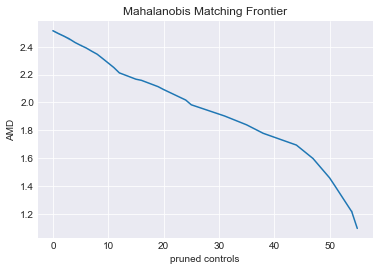

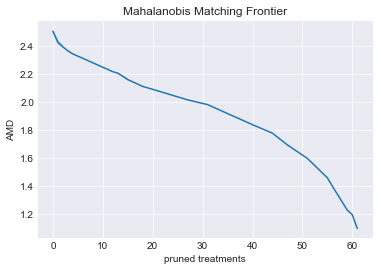

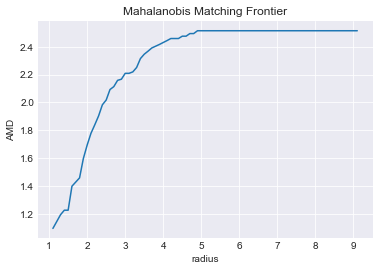

In [350]:
sns.lineplot(x='pruned controls', y='AMD', data=df_mf)
plt.title('Mahalanobis Matching Frontier')
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='pruned treatments', y='AMD', data=df_mf)
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='radius', y='AMD', data=df_mf)

We choose a reasonable radius/caliper to minimise difference in marginal distributions but also keep as many controls as possible. This is a little difficult because we're not working with very large sample sizes as it is.

In [351]:
df_matched = match_by_distance(df_career_, on, 'avg_rating', 'mahalanobis', caliper=3)

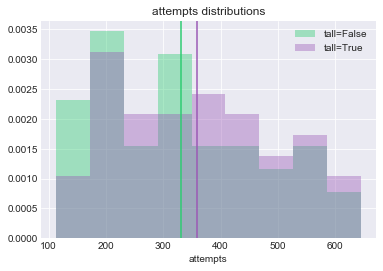

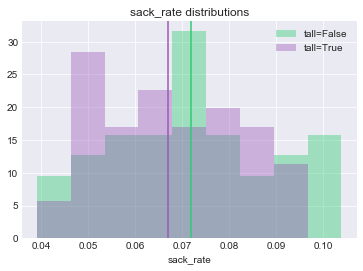

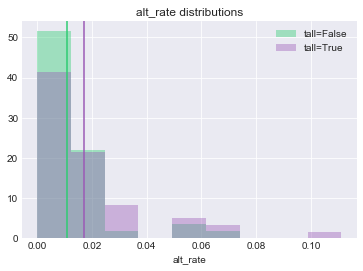

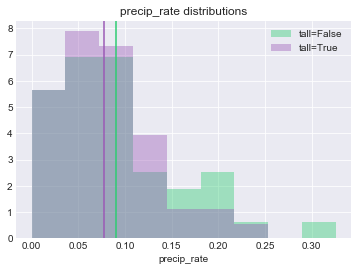

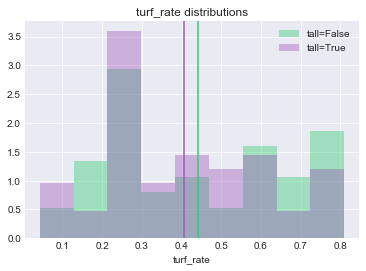

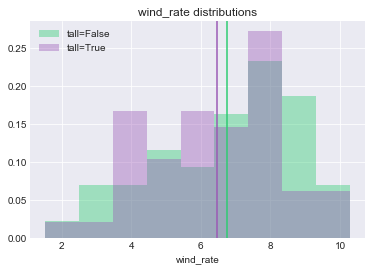

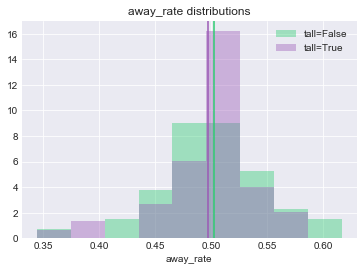

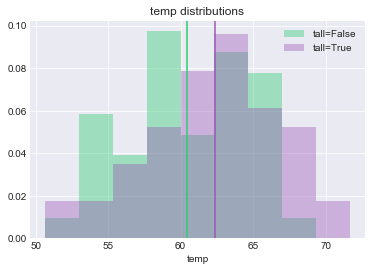

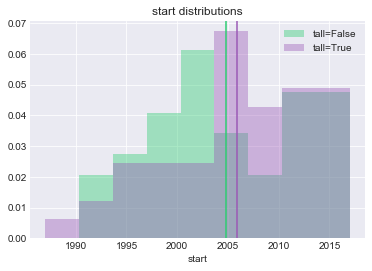

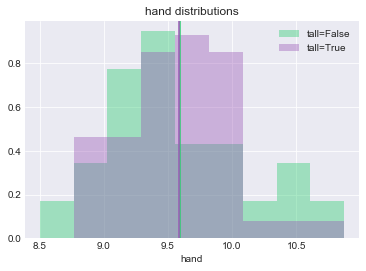

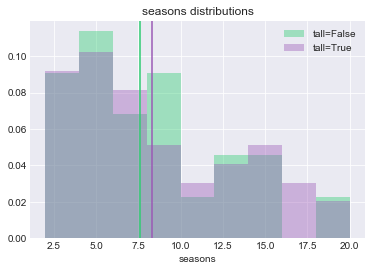

In [352]:
from util.matching import covariate_dists
covariate_dists(df_matched.drop('avg_rating', axis=1), on=on, kde=False, hist=True, n_bins=10)

We can perform a t-test for difference of sample means. We're more interested in distribution similarity, but large difference of means can indicate problems. The p value is the probability of observing such a difference between sample means given their population means are equal.

In [366]:
from scipy.stats import ttest_ind

for col in df_matched.drop(['avg_rating', on], axis=1).columns:
    rvs1 = df_matched.loc[df_matched[on], col]
    rvs2 = df_matched.loc[~df_matched[on], col]
    _, p = ttest_ind(rvs1, rvs2, equal_var = False)
    print(f'P(x|H0) for {col}: {round(p,2)}')

P(x|H0) for attempts: 0.35
P(x|H0) for sack_rate: 0.15
P(x|H0) for alt_rate: 0.13
P(x|H0) for precip_rate: 0.31
P(x|H0) for turf_rate: 0.43
P(x|H0) for wind_rate: 0.45
P(x|H0) for away_rate: 0.61
P(x|H0) for temp: 0.04
P(x|H0) for start: 0.47
P(x|H0) for hand: 0.91
P(x|H0) for seasons: 0.48


In [354]:
df_treatment = df_matched.loc[df_matched[on],:]
df_control = df_matched.loc[~df_matched[on], :]
print(len(df_treatment), f'{on} samples.', len(df_control), f'not {on} samples.')

49 tall samples. 44 not tall samples.


## Model

We'll use the BEST method for comparing means of the two groups.

In [355]:
treatment = df_treatment['avg_rating']
control = df_control['avg_rating']

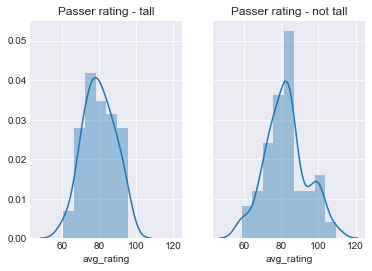

In [356]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True)
sns.distplot(treatment, ax=axes[0])
axes[0].set_title(f'Passer rating - {on}')
sns.distplot(control, ax=axes[1])
axes[1].set_title(f'Passer rating - not {on}')
plt.show()

Because of the relatively small sample sizes we assume our distributions are of the students-t distribution (Kruschke).
The students-t has a mean, variance, and degree-of-freedom.
The degree of freedom control the normality of the data (larger dof converges to normal distribution).

Lets set up the model

In [357]:
# priors on the mean
m_mu = pd.concat([control,treatment]).mean()
m_sd = pd.concat([control,treatment]).std()

with pm.Model() as model:
    treatment_mean = pm.Normal('treatment_mean', mu=m_mu, sd=m_sd)
    control_mean = pm.Normal('control_mean', mu=m_mu, sd=m_sd)

In [358]:
# priors on the standard deviation
sd_low = 1
sd_high = 30

with model:
    treatment_std = pm.Uniform('treatment_std', lower=sd_low, upper=sd_high)
    control_std = pm.Uniform('control_std', lower=sd_low, upper=sd_high)

In [359]:
# shared prior on the degree of freedom parameter
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

In [360]:
# pymc3 paramaterises students t with precision, rather than standard deviation (lambda = 1/sigma^2)
with model:
    treatment_lambda = treatment_std**-2  # deterministic
    control_lambda = control_std**-2 # deterministic

    treatment_rating = pm.StudentT(f'{on}', nu=v, mu=treatment_mean, lam=treatment_lambda, observed=treatment)
    control_rating = pm.StudentT(f'not {on}', nu=v, mu=control_mean, lam=control_lambda, observed=control)

In [361]:
with model:
    # our deterministic values, we could just have easily done this with the traces.
    diff_of_means = pm.Deterministic('difference_of_means', treatment_mean - control_mean)
    diff_of_stds = pm.Deterministic('difference_of_stds', treatment_std - control_std)
    effect_size = pm.Deterministic('effect_size',
                                   diff_of_means / np.sqrt((treatment_std**2 + control_std**2) / 2)) # hard to interpret but is difference scaled by pooled variance

In [362]:
with model:
    trace = pm.sample(2000) # NUTS sampling for filling our posterior

    # dump the trace
    today = dt.now().strftime('%y%m%d')
    with open(f'../results/trace_{on}_{today}.pckle', 'wb') as f:
        pickle.dump(trace, f)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_minus_one, control_std, treatment_std, control_mean, treatment_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:24<00:00, 203.79draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002859A27FA88>,
      dtype=object)

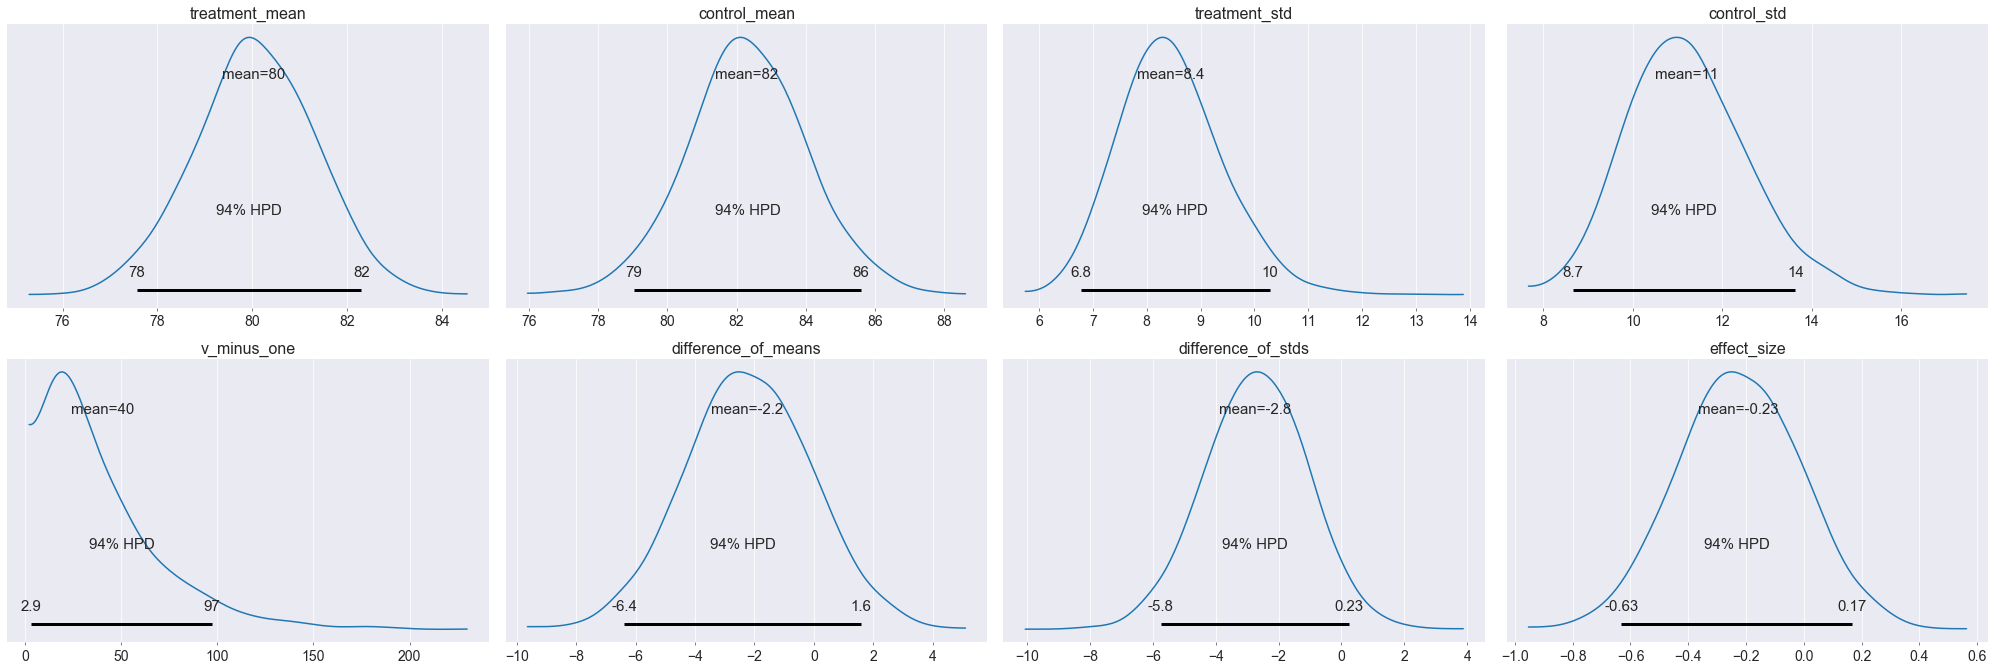

In [363]:
pm.plot_posterior(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000285A0FDA708>,
      dtype=object)

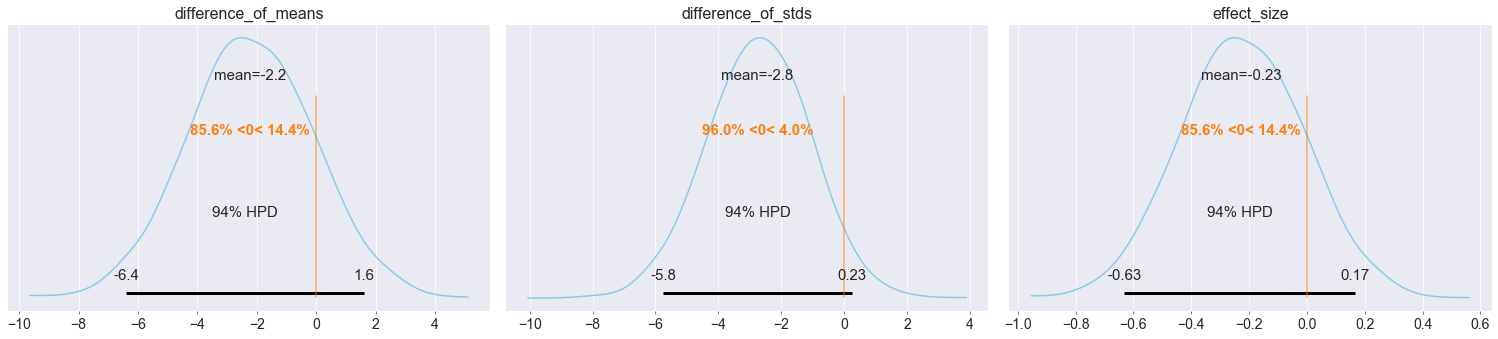

In [364]:
pm.plot_posterior(trace, var_names=['difference_of_means','difference_of_stds', 'effect_size'],
                  ref_val=0,
                  color='#87ceeb')

In [365]:
# the diagnostics show that the sampling went as suspected with no issues (Rhat ~ 1)
from util.stats import summary
summary_ = summary(trace)
summary_ # error out

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
treatment_mean,80.040740,1.258941,0.019538,77.568266,82.508516,3699.328446,0.999823
control_mean,82.282167,1.719770,0.023900,78.801172,85.621410,4101.404655,1.000284
treatment_std,8.442584,0.956164,0.016536,6.649910,10.301091,3280.771366,0.999842
control_std,11.199976,1.335939,0.018460,8.653430,13.863447,4594.979835,0.999894
v_minus_one,40.135276,31.092120,0.522869,2.181737,101.401466,3905.450051,0.999785
difference_of_means,-2.241427,2.109401,0.028913,-6.571549,1.740343,3475.557454,1.000323
difference_of_stds,-2.757392,1.615343,0.021308,-6.012006,0.241186,5024.009075,0.999994
effect_size,-0.227102,0.212649,0.002810,-0.653194,0.180453,3700.784650,1.000186


## TODO: Relative difference in means/lift.